EDA - STROKE PREDICTION

Based on the csv file, i want to do some simple analysis

1. Is the Age and the BMI of the patient related to the severity of the lesion?
The first data we're looking at is age, bmi, nihs score (which is the severity of the stroke 0-42), 
and the gs_rankin_6isdeath (which is the severity of the lesion 3 months after the stroke 1-6).

2. [TO-DO] What's the most common location of the lesion?
Look at those locations, and find out which of them had bigger problems, so that 
we can predict the severity of the lesion based on the location of the lesion.

====================================================
1. Import Libraries and Configure Settings      

====================================================

In [32]:
# Imports from the BluePrint:
%matplotlib inline
%pip install numpy
%pip install seaborn
# Importing the Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 10, 8
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Imports for Alihan:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
# Set a global plot size for individual plots
rcParams['figure.figsize'] = 10, 8
# Machine Learning and Data Preprocessing Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


====================================================    

2. Load the Data  

====================================================

In [33]:
# Replace 'stroke_data.csv' with the actual CSV filename if it differs.
data = pd.read_csv("data/processed/complete_per_patient_t1_volumetry.csv")

# Preview the data and list all column names
print("Data Preview:")
print(data.head())
print("\nAll Columns in the Dataset:")
print(data.columns.tolist())

Data Preview:
      ID  Total volume (direct)  Number of lesions  Main Side  ACAright  \
0  sub-2               0.880707           0.132130          1    10.424   
1  sub-3               2.184380           0.017070          0     0.400   
2  sub-5              -0.571408          -0.558231          1     0.035   
3  sub-8               0.824821           0.477311          1    55.660   
4  sub-9               0.021404          -0.443171          0     0.000   

   MCAright  PCAright  Pons/Medullaright  Cerebellumright  ACAleft  ...  \
0    75.990    21.287                0.0            0.000    3.280  ...   
1     0.557     0.000                0.0            7.167   24.304  ...   
2     1.120     0.000                0.0            0.000    0.000  ...   
3    32.249     0.319                0.0            0.000    8.454  ...   
4     0.000     0.000                0.0            0.000    2.533  ...   

   summ-cerebellum-white-matter  summ-cerebellum-cortex  summ-thalamus  \
0         

====================================================    

3. Data Cleaning & Filtering    

====================================================

In [34]:
# 3.1 Remove duplicate rows, if any
initial_shape = data.shape
data.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_shape[0] - data.shape[0]} duplicate rows.")

# Columns of interest for cleaning/analysis
cols_of_interest = ['sex', 'age', 'bmi', 'nihss', 'gs_rankin_6isdeath', 'acuteischaemicstroke']

# 3.2 Drop rows with missing values in columns of interest (example approach)
before_dropna_shape = data.shape
data.dropna(subset=cols_of_interest, inplace=True)
print(f"Removed {before_dropna_shape[0] - data.shape[0]} rows due to missing values in columns of interest.")

# 3.3 Convert or unify 'sex' values if needed
# Example: If 'sex' is coded as 1=male, 2=female, or M/F strings
sex_mapping = {
    1: 'male',
    2: 'female',
    'M': 'male',
    'F': 'female'
}
data['sex'] = data['sex'].replace(sex_mapping)

# 3.4 Filter outliers or invalid ranges (adjust thresholds as appropriate)
valid_age_mask = (data['age'] >= 0) & (data['age'] <= 120)
valid_bmi_mask = (data['bmi'] >= 10) & (data['bmi'] <= 50)
valid_nihss_mask = (data['nihss'] >= 0) & (data['nihss'] <= 42)
valid_rankin_mask = (data['gs_rankin_6isdeath'] >= 1) & (data['gs_rankin_6isdeath'] <= 6)

combined_mask = valid_age_mask & valid_bmi_mask & valid_nihss_mask & valid_rankin_mask
before_filter_shape = data.shape
data = data[combined_mask]
print(f"Removed {before_filter_shape[0] - data.shape[0]} rows due to out-of-range values.")

# Create a final cleaned subset with the columns of interest
# (Include 'acuteischaemicstroke' so we can visualize stroke counts)
clean_cols = ['sex', 'age', 'bmi', 'nihss', 'gs_rankin_6isdeath', 'acuteischaemicstroke']
data_subset = data[clean_cols]

print("\nCleaned Data Subset Preview:")
print(data_subset.head())
print("\nSummary of Cleaned Data Subset:")
print(data_subset.describe())


Removed 0 duplicate rows.
Removed 327 rows due to missing values in columns of interest.
Removed 72 rows due to out-of-range values.

Cleaned Data Subset Preview:
     sex  age    bmi  nihss  gs_rankin_6isdeath  acuteischaemicstroke
1      0   87  19.23   15.0                 6.0                   1.0
4      0   70  26.89   18.0                 4.0                   1.0
7   male   72  30.48    0.0                 2.0                   1.0
12  male   41  23.67   14.0                 2.0                   1.0
15  male   76  30.04    1.0                 1.0                   1.0

Summary of Cleaned Data Subset:
              age         bmi       nihss  gs_rankin_6isdeath  \
count  484.000000  484.000000  484.000000          484.000000   
mean    64.229339   28.138202   10.316116            3.041322   
std     14.495201    6.266422    8.393362            1.575678   
min     19.000000   12.800000    0.000000            1.000000   
25%     55.000000   23.962500    3.000000            2.000

====================================================    

4. Correlation Analysis (Cleaned Data)  

====================================================

In [35]:
numeric_cols = ['age', 'bmi', 'nihss', 'gs_rankin_6isdeath']
corr_matrix = data_subset[numeric_cols].corr()
print("\nCorrelation Matrix (Cleaned Data):")
print(corr_matrix)


Correlation Matrix (Cleaned Data):
                         age       bmi     nihss  gs_rankin_6isdeath
age                 1.000000 -0.119563 -0.013496            0.109722
bmi                -0.119563  1.000000 -0.053369           -0.026614
nihss              -0.013496 -0.053369  1.000000            0.450966
gs_rankin_6isdeath  0.109722 -0.026614  0.450966            1.000000


====================================================    

5. Original Grid of Plots (Scatter, Box, Heatmap)   

====================================================

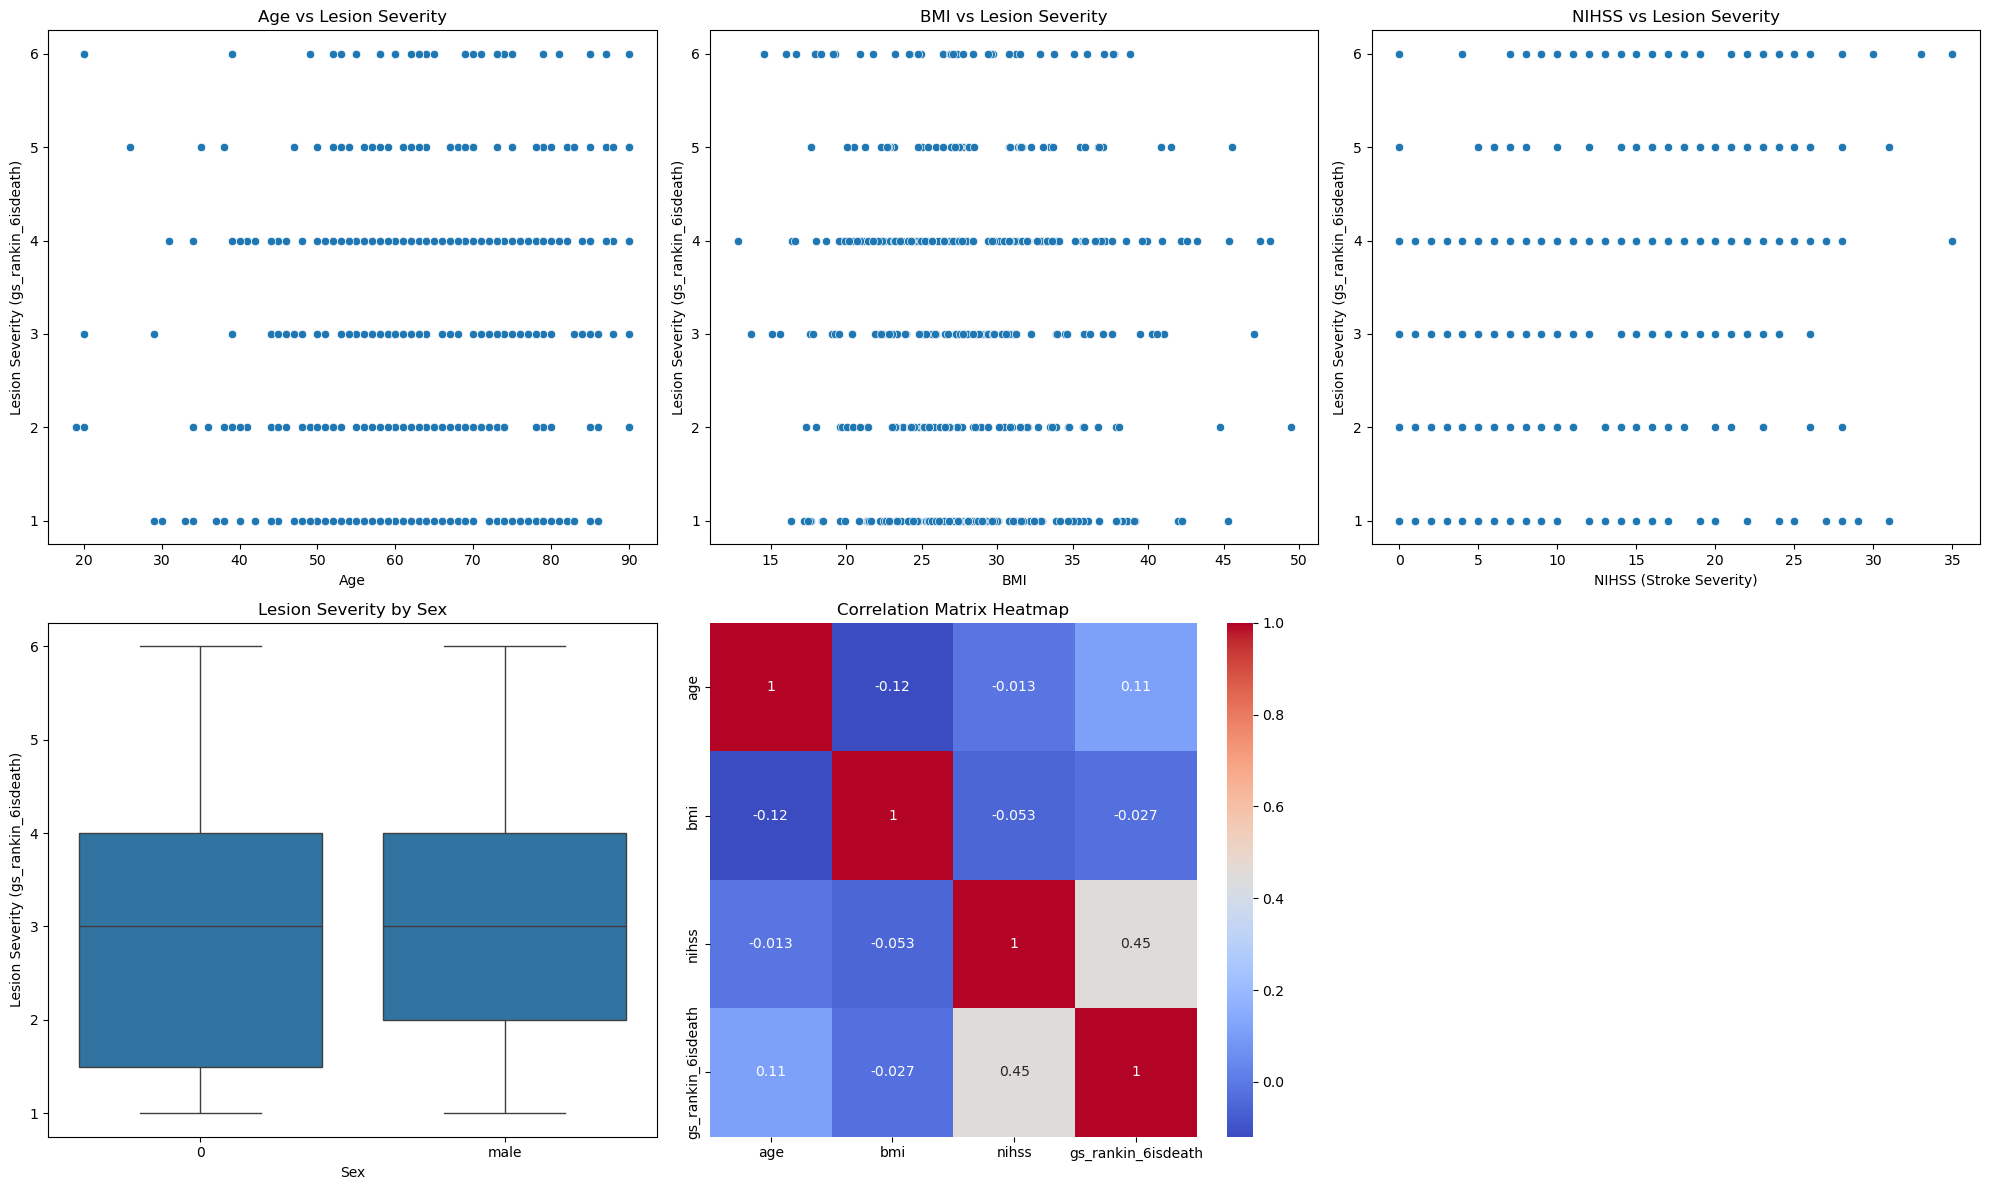

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Age vs Lesion Severity
sns.scatterplot(ax=axs[0, 0], x='age', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 0].set_title('Age vs Lesion Severity')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 2: BMI vs Lesion Severity
sns.scatterplot(ax=axs[0, 1], x='bmi', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 1].set_title('BMI vs Lesion Severity')
axs[0, 1].set_xlabel('BMI')
axs[0, 1].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 3: NIHSS vs Lesion Severity
sns.scatterplot(ax=axs[0, 2], x='nihss', y='gs_rankin_6isdeath', data=data_subset)
axs[0, 2].set_title('NIHSS vs Lesion Severity')
axs[0, 2].set_xlabel('NIHSS (Stroke Severity)')
axs[0, 2].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 4: Boxplot - Lesion Severity by Sex
sns.boxplot(ax=axs[1, 0], x='sex', y='gs_rankin_6isdeath', data=data_subset)
axs[1, 0].set_title('Lesion Severity by Sex')
axs[1, 0].set_xlabel('Sex')
axs[1, 0].set_ylabel('Lesion Severity (gs_rankin_6isdeath)')

# Plot 5: Heatmap - Correlation Matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Correlation Matrix Heatmap')

# Leave the 6th subplot empty or for future use
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

====================================================    

6. Additional Plots: Stroke Patients' Age & BMI Distributions   

====================================================

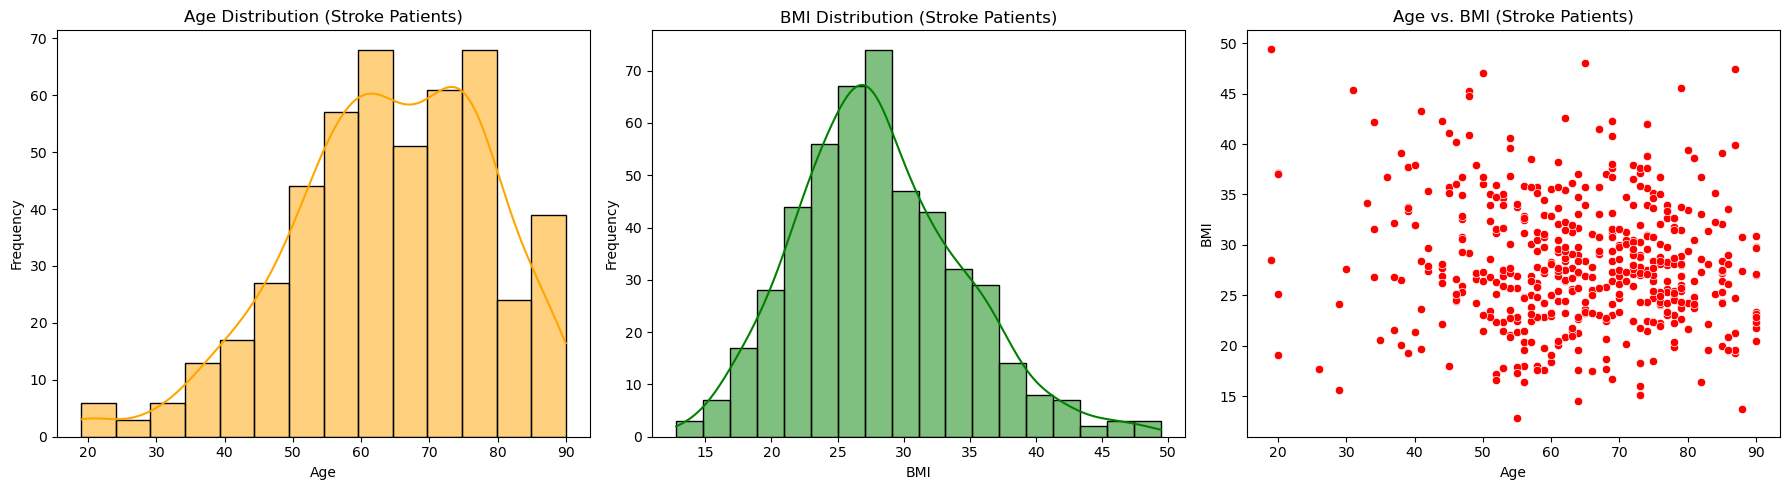

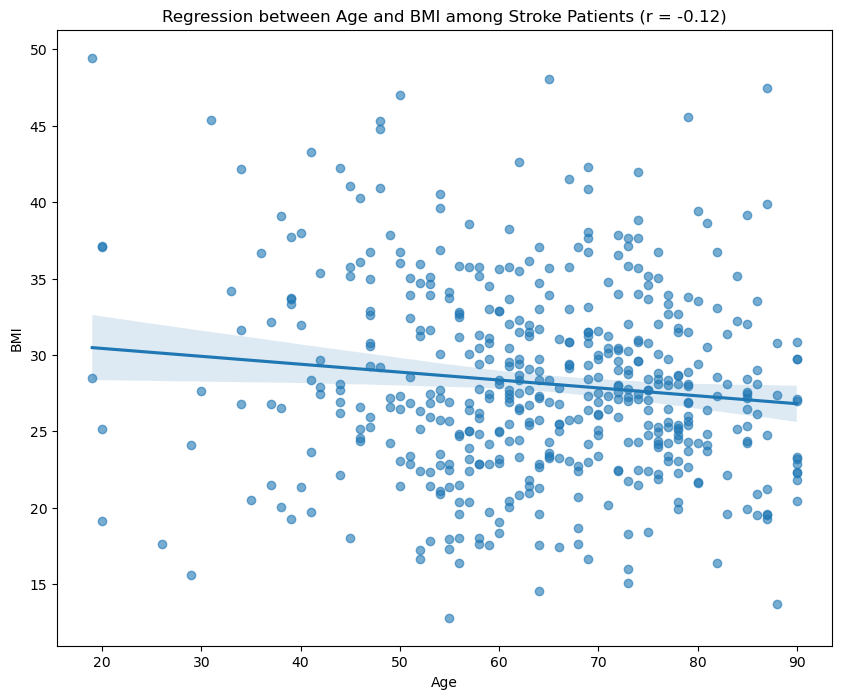

In [37]:
# Filter data for stroke patients only
stroke_data = data[data['acuteischaemicstroke'] == 1]

# Arrange the three plots in a 1x3 grid.
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))

# 6.1 Age Distribution for Stroke Patients
sns.histplot(stroke_data['age'], kde=True, ax=axs2[0], color='orange')
axs2[0].set_title("Age Distribution (Stroke Patients)")
axs2[0].set_xlabel("Age")
axs2[0].set_ylabel("Frequency")

# 6.2 BMI Distribution for Stroke Patients
sns.histplot(stroke_data['bmi'], kde=True, ax=axs2[1], color='green')
axs2[1].set_title("BMI Distribution (Stroke Patients)")
axs2[1].set_xlabel("BMI")
axs2[1].set_ylabel("Frequency")

# 6.3 Combined Scatter: Age vs. BMI (Stroke Patients)
sns.scatterplot(x='age', y='bmi', data=stroke_data, ax=axs2[2], color='red')
axs2[2].set_title("Age vs. BMI (Stroke Patients)")
axs2[2].set_xlabel("Age")
axs2[2].set_ylabel("BMI")

plt.tight_layout()
plt.show()

# ====================================================
# 7. Mixed Analysis: Regression between Age and BMI among Stroke Patients
# ====================================================
# Compute the Pearson correlation coefficient between Age and BMI.
corr_val = stroke_data['age'].corr(stroke_data['bmi'])

# Create a plot with a regression line.
plt.figure(figsize=(10, 8))
sns.regplot(data=stroke_data, x='age', y='bmi', scatter_kws={'alpha': 0.6})
plt.title(f"Regression between Age and BMI among Stroke Patients (r = {corr_val:.2f})")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.show()